In [1]:
# import packages and libraries
import pandas as pd
import numpy as np
import collections
import csv
from itertools import repeat
from functools import reduce
import matplotlib.pyplot as plt
import lifetimes
from lifetimes import BetaGeoFitter, ParetoNBDFitter, GammaGammaFitter
from lifetimes.datasets import load_dataset, load_cdnow_summary
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
# create parameters for period of time
t1=int(365)

In [3]:
# load in the cdnow customer transactions dataset
transactions = load_dataset(filename='CDNOW_sample.txt',header=None,delim_whitespace=True,
                            names=['customer_id', 'customer_index', 'date', 'quantity', 'amount'],
                            converters={'date':lambda x:pd.to_datetime(x,format="%Y%m%d")})
print(transactions.shape)
transactions.head()

(6919, 5)


,customer_id,customer_index,date,quantity,amount
0,4,1,1997-01-01,2,29.33
1,4,1,1997-01-18,2,29.73
2,4,1,1997-08-02,1,14.96
3,4,1,1997-12-12,2,26.48
4,21,2,1997-01-01,3,63.34


In [4]:
# create a summary from transactions data where each customer has recency, frequency..
data = summary_data_from_transaction_data(transactions=transactions,customer_id_col='customer_id', datetime_col='date',monetary_value_col='amount', 
                                          observation_period_end=pd.to_datetime('1998-06-30'),freq='D')
print(data.shape)
data.head()

(2357, 4)


,frequency,recency,T,monetary_value
customer_id,,,,
4,3.00,345.00,545.00,23.72
18,0.00,0.00,542.00,0.00
21,1.00,12.00,545.00,11.77
50,0.00,0.00,545.00,0.00
60,0.00,0.00,514.00,0.00


In [5]:
# check data types and for any missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2357 entries, 4 to 23569
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       2357 non-null   float64
 1   recency         2357 non-null   float64
 2   T               2357 non-null   float64
 3   monetary_value  2357 non-null   float64
dtypes: float64(4)
memory usage: 92.1 KB


In [6]:
# fit the lifetimes BGF algorithm
bgf=BetaGeoFitter(penalizer_coef=0.01) # .001 to .1 used for L2 regularization to avoid overfitting
bgf.fit(data['frequency'],data['recency'],data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.25, alpha: 37.99, b: 0.78, r: 0.25>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

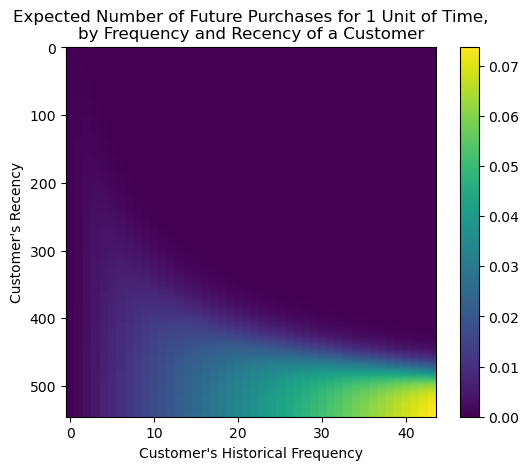

In [7]:
# plot the future number of purchases for 1 unit of time
plot_frequency_recency_matrix(bgf)

# Best Customer would be in lower right corner with highest frequency and recency

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

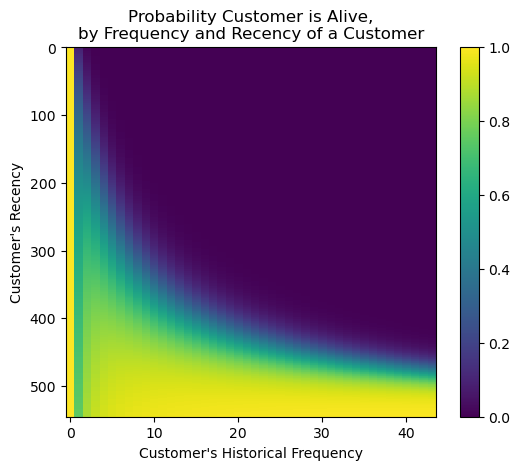

In [8]:
# plot the prob alive matrix
plot_probability_alive_matrix(bgf)

# The visualization above shows a high probability alive with high recency and high frequency.  Low frequency still has a high probability alive if the recency is high however low recency does not have a high probability alive if the frequency is high so the recency seems to have more impact on the probability alive in this visualization

<Figure size 1200x1200 with 0 Axes>

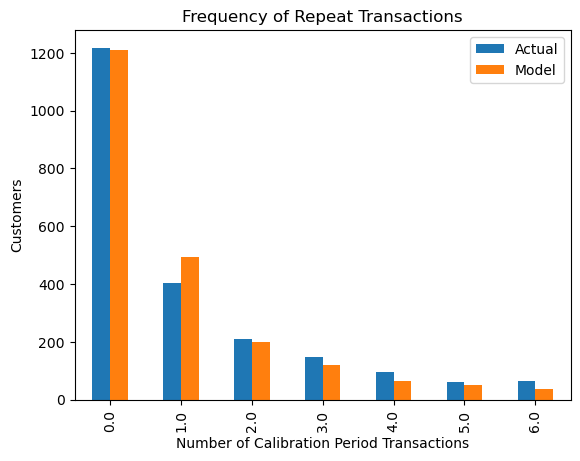

In [9]:
# take a look at how well the model predicts
fig = plt.figure(figsize=(12,12))
plot_period_transactions(bgf);

In [10]:
# function for bgf model so that time period is data-driven and dynamic
def calcTime(dataframe,t):
    dataframe["predicted_purchases_" + str(t)]= bgf.conditional_expected_number_of_purchases_up_to_time(t,dataframe['frequency'],dataframe['recency'],dataframe['T'])
    dataframe['prob_alive'] = bgf.conditional_probability_alive(dataframe['frequency'], dataframe['recency'],dataframe['T'])
    return dataframe

In [11]:
# call functions for different time periods
bgf1=calcTime(data, t1).reset_index().reset_index()
print(bgf1.shape)
bgf1.head()

(2357, 8)


,index,customer_id,frequency,recency,T,monetary_value,predicted_purchases_365,prob_alive
0,0,4,3.00,345.00,545.00,23.72,1.40,0.74
1,1,18,0.00,0.00,542.00,0.00,0.15,1.00
2,2,21,1.00,12.00,545.00,11.77,0.09,0.12
3,3,50,0.00,0.00,545.00,0.00,0.15,1.00
4,4,60,0.00,0.00,514.00,0.00,0.15,1.00


In [12]:
# create dataframe to calculate customer avg profit(for accuracy remove frequency=0);add prob not alive column
customer_df = bgf1[bgf1['frequency']>0]
customer_df['prob_not_alive'] = 1 - customer_df['prob_alive']
print(customer_df.shape)
customer_df.head()

(1139, 9)


,index,customer_id,frequency,recency,T,monetary_value,predicted_purchases_365,prob_alive,prob_not_alive
0,0,4,3.00,345.00,545.00,23.72,1.40,0.74,0.26
2,2,21,1.00,12.00,545.00,11.77,0.09,0.12,0.88
7,7,111,15.00,535.00,545.00,71.40,8.74,0.98,0.02
8,8,112,1.00,35.00,545.00,11.77,0.14,0.19,0.81
9,9,113,2.00,430.00,545.00,13.38,1.07,0.81,0.19


In [13]:
# fit the gamma gamma fitter model for CLV
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(customer_df['frequency'], customer_df['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1139 subjects, p: 7.96, q: 2.48, v: 7.50>

In [14]:
# examine if avg profit is valuable to final output
avg_profit=ggf.conditional_expected_average_profit(customer_df['frequency'],customer_df['monetary_value'])
df_avg_profit=avg_profit.to_frame("avg_profit").reset_index()
df_avg_profit.head()

,index,avg_profit
0,0,24.69
1,2,16.24
2,7,71.02
3,8,16.24
4,9,15.67


In [15]:
# calculate conditional avg profit across all customer IDs
print("Expected condtional average profit: %s, Average profit: %s" % (ggf.conditional_expected_average_profit(
customer_df['frequency'], customer_df['monetary_value']).mean(),
customer_df[customer_df['frequency']>0]['monetary_value'].mean()))

Expected condtional average profit: 36.290571994118004, Average profit: 35.78440858463762


In [16]:
# refit bgf model to customer_dfs data and use test data for ggf model
bgf.fit(customer_df['frequency'],customer_df['recency'],customer_df['T'])

<lifetimes.BetaGeoFitter: fitted with 1139 subjects, a: 0.36, alpha: 112.00, b: 0.89, r: 1.55>

In [17]:
# write a function for the model so that way any time period can be calculated
def customerLV(dataframe, t):
    time = round(t/30.417)
    customer_lv=ggf.customer_lifetime_value(bgf,
    dataframe['frequency'], dataframe['recency'],dataframe['T'],dataframe['monetary_value'],
    time=time,
    discount_rate=0.01)
    clv_df=customer_lv.to_frame("predicted_CLV_" + str(t))
    clv_df.reset_index(inplace=True)
    return clv_df

In [18]:
# call the function
clv=customerLV(customer_df,t1)
print(clv.shape)
clv.head()

(1139, 2)


,index,predicted_CLV_365
0,0,31.63
1,2,0.64
2,7,537.11
3,8,0.97
4,9,18.62


In [19]:
# create one dataframe with all time predicted columns and merged on index
customers_df = reduce(lambda left,right:pd.merge(left, right, on='index', how='inner'),[clv, df_avg_profit, customer_df])
print(customers_df.shape)
customers_df.head()

(1139, 11)


,index,predicted_CLV_365,avg_profit,customer_id,frequency,recency,T,monetary_value,predicted_purchases_365,prob_alive,prob_not_alive
0,0,31.63,24.69,4,3.00,345.00,545.00,23.72,1.40,0.74,0.26
1,2,0.64,16.24,21,1.00,12.00,545.00,11.77,0.09,0.12,0.88
2,7,537.11,71.02,111,15.00,535.00,545.00,71.40,8.74,0.98,0.02
3,8,0.97,16.24,112,1.00,35.00,545.00,11.77,0.14,0.19,0.81
4,9,18.62,15.67,113,2.00,430.00,545.00,13.38,1.07,0.81,0.19
